# Profiling tiling of titiler-pgstac and titiler-xarray

This notebook profiles code for tiling CMIP6 data via 2 methods:

1. pgSTAC + COGs: The first method uses a (local or remote) pgSTAC database for storing metadata about COGs on S3. The libraries used are pgstac for reading STAC metadata and rio_tiler's rasterio for reading COGs on S3.
2. kerchunk + netCDF: The second method uses a (local or S3) kerchunk reference file for NetCDF files stored on S3. The libraries used are xarray for reading the Zarr metadata and rio_tiler's XarrayReader for reading data from the NetCDFs on S3.
3. Zarr stores with different chunking configurations and pyramids.

In the future, the following improvements and additions to this profiling code will be made:

1. Use carbonplan's datasets
3. Test a higher resolution dataset.

# Findings: Executive summary

1. pgSTAC + COGs is fastest, assuming GDAL environment variables are configured optimally
2. tiling using Zarr really depends on the chunking structure. Make sure that:
   1. if optimizing for spatial visualization and not time series, only store 1 time step per chunk
   2. Make sure the coordinates themselves are not chunked, otherwise this will require a lot of fetches when loading the dataset.
3. If the data resolution is finer than ~3km, it is recommended to create a pyramid. Pyramids generate low resolution versions of the dataset.

## Setup / Step 0

1. Load some basic libraries and set environment variables for AWS access
2. Initiate tileset to test

In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import boto3
from datetime import datetime
import io
from IPython.display import display
from PIL import Image
import os
import warnings
from matplotlib.pyplot import imshow
import morecantile
import numpy as np
import pandas as pd
from profiler.main import Timer, cprofile_list_to_dict
import sys
sys.path.append('..')

import eodc_hub_role
credentials = eodc_hub_role.fetch_and_set_credentials()
import profile_pgstac
pool = profile_pgstac.connect_to_database(credentials)

warnings.filterwarnings('ignore')

Caught exception: An error occurred (InvalidPermission.Duplicate) when calling the AuthorizeSecurityGroupIngress operation: the specified rule "peer: 54.213.127.201/32, TCP, from port: 5432, to port: 5432, ALLOW" already exists
Connected to database


In [3]:
tms = morecantile.tms.get("WebMercatorQuad")
zooms = range(12) # Zoom 10 is the level at which you can see large roads, 15 is buildings
xyz_tiles = []
for z in zooms:
    # lat/lon over central park
    tile = tms.tile(-73.97, 40.78, z)
    xyz_tiles.append((tile.x, tile.y, tile.z))

xyz_tiles

[(0, 0, 0),
 (0, 0, 1),
 (1, 1, 2),
 (2, 3, 3),
 (4, 6, 4),
 (9, 12, 5),
 (18, 24, 6),
 (37, 48, 7),
 (75, 96, 8),
 (150, 192, 9),
 (301, 384, 10),
 (603, 769, 11)]

In [4]:
#parameters
temporal_resolution = "daily"
model = "GISS-E2-1-G"
variable = "tas"
anon=True

## Profile titiler-pgstac

GDAL environment variables are an important factor to delivering performant tiling using rasterio.

These GDAL variables are documented here https://developmentseed.org/titiler/advanced/performance_tuning/, but that advice is copied into comments below for ease of reference.

In [5]:
gdal_env_vars = {
    # By default GDAL reads the first 16KB of the file, then if that doesn't contain the entire metadata
    # it makes one more request for the rest of the metadata.
    # In environments where latency is relatively high, AWS S3,
    # it may be beneficial to increase this value depending on the data you expect to read.    
    'GDAL_INGESTED_BYTES_AT_OPEN': '32768',
    # It's much better to set EMPTY_DIR because this prevents GDAL from making a LIST request.
    # LIST requests are made for sidecar files, which does not apply for COGs.  
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    # Tells GDAL to merge consecutive range GET requests.    
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES',
    # When set to YES, this attempts to download multiple range requests in parallel, reusing the same TCP connection. 
    # Note this is only possible when the server supports HTTP2, which many servers don't yet support.
    # There's no downside to setting YES here.    
    'GDAL_HTTP_MULTIPLEX': 'YES',
    'GDAL_HTTP_VERSION': '2',
    # Setting this to TRUE enables GDAL to use an internal caching mechanism. It's recommended (strongly).    
    'VSI_CACHE': 'TRUE'
}

def set_or_unset_gdal(set_vars=True):
    if set_vars:
        for key, value in gdal_env_vars.items():
            os.environ[key] = value
    else:
        for key, value in gdal_env_vars.items():
            os.environ.pop(key, None)
    return

Below we test tiling with and without gdal environment variables to demonstrate the magnitude of their importance when tiling with rasterio.

In [6]:
if temporal_resolution == 'daily':
    collection = f"CMIP6_daily_{model}_{variable}"
elif temporal_resolution == 'monthly':
    collection = f"CMIP6_ensemble_monthly_median_{variable}"

query = {
  "collections": [ collection ],
  "filter": {
    "op": "t_intersects",
    "args": [
      {
        "property": "datetime"
      },
      {
        "interval": [
          "1950-04-01T00:00:00Z"           
        ]
      }
    ]
  },
  "filter-lang": "cql2-json"
}

gdal_results_dict = {}
# We don't need many iterations since the variation is so great.
niters = 3
xyz_tile = (0,0,0)
for settings in ['with_gdal_vars', 'without_gdal_vars']:
    gdal_results_dict[settings] = { 'tile times': [], 'mean total time': None }
    if settings == 'with_gdal_vars':
        set_or_unset_gdal(set_vars=True)
    else:
        set_or_unset_gdal(set_vars=False)
    for iter in range(niters):
        with Timer() as t:
            image_and_assets, cprofile = profile_pgstac.tile(pool, *xyz_tile, query=dict(query))
        gdal_results_dict[settings]['tile times'].append(round(t.elapsed * 1000, 2))
    gdal_results_dict[settings]['mean total time'] = np.mean(gdal_results_dict[settings]['tile times'])
    

We don't need many iterations since the variation is so great.
You can see that setting GDAL environment variables makes things at least 100x faster.

By setting the GDAL environment variables we limit the number of total requests to S3. 

Specifically, these environment variables ensure that:
* All of the metadata may be read in 1 request. This is not necessarily true, but more likely since we increase the initial number of GDAL ingested bytes.
* There is no superfluous LIST request to account for sidecar files, which don't exist for COGs.
* Consecutive range requests are merged into 1 request.
* Multiple range requests use the same TCP connection.


In [7]:
gdal_results_df = pd.DataFrame.from_dict(gdal_results_dict, orient='index')
gdal_results_df.to_csv('results/pgstac_cog_gdal_results.csv', index_label='gdal_vars_set?')
gdal_results_df

,tile times,mean total time
with_gdal_vars,"[342.99, 53.75, 52.85]",149.863333
without_gdal_vars,"[16064.17, 27977.9, 15404.97]",19815.680000


## Testing different tiles for COGs

Nothing is too interesting or surprising here, all tiles are relatively fast to produce.

In [8]:
# Results for different tiles
tile_results_dict = {}
niters = 10
set_or_unset_gdal(set_vars=True)
for xyz_tile in xyz_tiles:
    tile_results_dict[xyz_tile] = { 'tile times': [], 'mean total time': None }
    results_timings = tile_results_dict[xyz_tile]
    for iter in range(niters):
        with Timer() as t:
            image_and_assets, cprofile = profile_pgstac.tile(pool, *xyz_tile, query=dict(query))
        results_timings['tile times'].append(round(t.elapsed * 1000, 2))
    results_timings['mean total time'] = np.mean(results_timings['tile times'])

In [9]:
tile_results_df = pd.DataFrame.from_dict(tile_results_dict, orient='index')
tile_results_df.to_csv('results/pgstac_cog_tile_results.csv', index_label='xyz tile')
tile_results_df

tile times  mean total time
0   0   0   [57.42, 55.06, 56.9, 58.15, 55.74, 59.9, 56.86...           56.906
        1   [79.98, 46.6, 46.95, 45.39, 44.84, 45.65, 54.5...           50.653
1   1   2   [65.78, 44.53, 65.17, 50.72, 53.75, 47.44, 45....           51.082
2   3   3   [81.39, 52.19, 47.49, 45.44, 45.5, 45.44, 45.4...           49.994
4   6   4   [74.54, 43.64, 43.55, 43.28, 44.46, 44.14, 43....           46.610
9   12  5   [53.3, 43.1, 52.24, 48.87, 49.74, 47.12, 47.26...           48.918
18  24  6   [61.07, 51.29, 47.15, 46.96, 52.16, 51.15, 47....           50.637
37  48  7   [59.29, 49.82, 51.7, 47.8, 46.41, 49.88, 51.58...           50.018
75  96  8   [62.08, 48.46, 49.16, 50.9, 48.48, 47.05, 49.9...           50.226
150 192 9   [59.74, 43.7, 42.34, 41.45, 50.96, 46.93, 47.9...           63.509
301 384 10  [62.72, 47.61, 46.17, 48.4, 50.6, 43.73, 51.26...           49.254
603 769 11  [52.47, 42.57, 52.09, 47.51, 46.74, 51.42, 52....           50.368

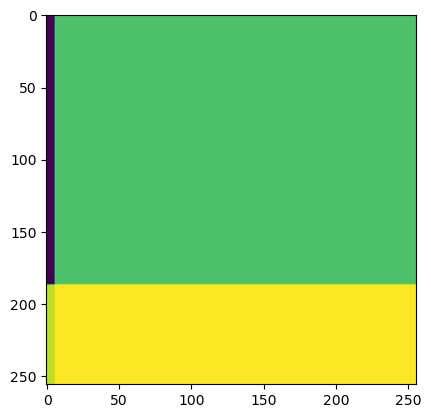

In [10]:
image = image_and_assets[0].data_as_image()
imshow(image)

# Profile titiler-xarray

In [11]:
bucket = 'nasa-eodc-data-store'
chunk_set_paths = ['600_1440_1', '600_1440_1_no-coord-chunks', '600_1440_29', '365_262_262']

# Different chunk shapes and sizes

Below we create a table with the chunk shape and size for each dataset, which will help us interpret the results of the tile benchmarks.

Note: The pyramid store is only reported for 1 sub-dataset, however we know how the dataset was generated so we can assume the chunk size will be the same for all sub-datasets since it is chunked 128x128. However, for different sub-datsets the chunk shape will be different.

In [12]:
%load_ext autoreload
%autoreload

import zarr_reader
import zarr_helpers

In [13]:
datastores = { 
    'kerchunk': {
        "data_store_path": f"combined_CMIP6_{temporal_resolution}_{model}_{variable}_kerchunk.json"
    }
}

for chunk_set_path in chunk_set_paths:
    datastores[chunk_set_path] = {
        'data_store_path': f"{chunk_set_path}/CMIP6_{temporal_resolution}_{model}_{variable}.zarr"
    }

for key, datastore in datastores.items():
    reference, anon, multiscale, z = False, False, False, 0
    if key == 'kerchunk':
        reference = True
    if 'pyramid' in key:
        multiscale = True
    if bucket == 'carbonplan-benchmarks':
        anon = True
    
    dataset_url = f"s3://{bucket}/{datastore['data_store_path']}"

    ds = zarr_helpers.open_dataset(dataset_url, reference, anon, multiscale, z)
    ds_specs = zarr_helpers.get_dataset_specs(key, dataset_url, variable, ds)
    datastores[key] = ds_specs

In [17]:
datastores_df = pd.DataFrame.from_dict(datastores, orient='index')
datastores_df.to_csv('results/profiled_zarr_datastores.csv', index=False)
datastores_df

,source,collection_name,variable,shape,lat_resolution,lon_resolution,chunk_size_mb,chunks,dtype,number_coord_chunks,compression
kerchunk,s3://nasa-eodc-data-store/combined_CMIP6_daily...,kerchunk,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,3.295898,"{'time': 1, 'lat': 600, 'lon': 1440}",float32,3,Zlib(level=5)
600_1440_1,s3://nasa-eodc-data-store/600_1440_1/CMIP6_dai...,600_1440_1,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,3.295898,"{'time': 1, 'lat': 600, 'lon': 1440}",float32,732,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, ..."
600_1440_1_no-coord-chunks,s3://nasa-eodc-data-store/600_1440_1_no-coord-...,600_1440_1_no-coord-chunks,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,3.295898,"{'time': 1, 'lat': 600, 'lon': 1440}",float32,3,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, ..."
600_1440_29,s3://nasa-eodc-data-store/600_1440_29/CMIP6_da...,600_1440_29,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,95.581055,"{'time': 29, 'lat': 600, 'lon': 1440}",float32,27,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, ..."
365_262_262,s3://nasa-eodc-data-store/365_262_262/CMIP6_da...,365_262_262,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,95.577469,"{'time': 365, 'lat': 262, 'lon': 262}",float32,9,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, ..."


## Test different tiles

Below we test the time to generate tiles from each datastore 10 times.

### What we learned

* The time to create a tile most depends on the time to open the dataset (how much time it takes to read the metadata files) and time to reproject the data. The latter largely depends on the size of the chunks being loaded from S3.
* Time to open depends on how many metadata files there are to read, which depends on how the data is chunked. A greater number of chunks means more coordiante chunks need to be read from S3. For example,
    * the chunk store with a chunk on each timestep has 732 coordinate chunks (730 time coordinate chunks to read (plus 1 lat and 1 lon).
    * The chunk store with 29 time steps has 29 time steps to read plus 1 lat and 1 lon.
    * The chunk store chunked spatially (365, 262, 262) has 2 coordinate time chunks, 3 latitude and 6 longitude (11 total).
* Time to reproject depends on the size of the chunk being reprojected.
* The kerchunk store is fast because even though it is chunked by time, all the metadata is loaded from 1 file (the kerchunk reference file).
* The pyramid is almost as fast but the chunks are a bit larger and there are multiple coordinate files to read so it is still slower than the kerchunk dataset.
* Use `import s3fs; s3fs.core.setup_logging("DEBUG")` to debug calls to S3.

In [14]:
niters = 10
tile_results_df = {}
dataset_chunk_sizes = {}
results_df = datastores.copy()

for xyz_tile in xyz_tiles:
    results_df[xyz_tile] = {}
    for dataset in datastores.keys():
        dataset_url = datastores[dataset]['source']
        reference, group = False, None
        if dataset == 'kerchunk':
            reference = True
        if 'pyramid' in dataset:
            group = xyz_tile[-1]

        results_df[xyz_tile][dataset] = {
            'total time (ms)': []
        }
        timings_results = results_df[xyz_tile][dataset]
        for iter in range(niters):
            with Timer() as t:
                with zarr_reader.ZarrReader(
                    src_path=dataset_url,
                    reference=reference,
                    variable=variable,
                    group=group
                ) as src:
                    try:
                        image = src.tile(*xyz_tile)
                    except Exception as e:
                        print(e);
            total_time = round(t.elapsed * 1000, 2)

            timings_results['total time (ms)'].append(total_time)
        timings_results['mean total time (ms)'] = np.mean(timings_results['total time (ms)'])

In [18]:
# Add the 0, 0, 0 tile result to the datastores_df
datasets_with_results = datastores_df.copy()
column = 'mean total time (ms)'

for xyz_tile in xyz_tiles:
    print(f"Results for {xyz_tile}")
    df = pd.DataFrame.from_dict(results_df[xyz_tile], orient='index')
    join_df = pd.DataFrame()
    join_df[f"zoom {xyz_tile[-1]}"] = df[[column]]
    datasets_with_results = datasets_with_results.join(join_df)
    display(df.sort_values('mean total time (ms)')); print();

Results for (0, 0, 0)


,total time (ms),mean total time (ms)
600_1440_1_no-coord-chunks,"[263.78, 253.8, 206.02, 168.3, 192.27, 169.67,...",200.876
kerchunk,"[829.43, 145.43, 149.98, 132.39, 128.23, 125.3...",219.537
600_1440_29,"[938.9, 681.58, 745.32, 657.39, 660.21, 666.11...",699.789
365_262_262,"[1514.5, 1572.43, 1418.29, 1431.86, 1375.51, 1...",1430.254
600_1440_1,"[1599.14, 1836.39, 1816.58, 1586.57, 1547.13, ...",1690.967



Results for (0, 0, 1)


,total time (ms),mean total time (ms)
kerchunk,"[161.98, 130.9, 149.11, 132.67, 130.08, 125.95...",134.376
600_1440_1_no-coord-chunks,"[237.97, 208.93, 163.07, 244.79, 160.05, 166.0...",190.096
600_1440_29,"[650.14, 664.58, 651.96, 643.78, 644.62, 646.3...",661.394
365_262_262,"[966.76, 924.79, 850.93, 875.47, 872.12, 863.4...",885.755
600_1440_1,"[1522.79, 1828.13, 1510.39, 1857.87, 1529.84, ...",1666.589



Results for (1, 1, 2)


,total time (ms),mean total time (ms)
kerchunk,"[168.76, 253.47, 128.8, 130.23, 136.67, 122.38...",151.662
600_1440_1_no-coord-chunks,"[197.32, 190.59, 148.91, 148.13, 152.99, 168.2...",173.674
600_1440_29,"[636.35, 654.59, 696.42, 657.88, 636.12, 647.8...",657.569
365_262_262,"[756.95, 692.54, 770.77, 713.17, 708.65, 753.6...",721.309
600_1440_1,"[1849.18, 1564.42, 1535.3, 1806.29, 1542.22, 1...",1680.811



Results for (2, 3, 3)


,total time (ms),mean total time (ms)
kerchunk,"[196.45, 144.4, 132.01, 129.7, 144.45, 129.61,...",140.098
600_1440_1_no-coord-chunks,"[160.59, 148.97, 152.52, 153.18, 161.16, 151.4...",164.986
600_1440_29,"[660.62, 637.57, 677.74, 645.5, 890.09, 685.02...",681.423
365_262_262,"[691.65, 695.06, 702.97, 698.12, 757.76, 689.4...",723.571
600_1440_1,"[1786.27, 1546.72, 1778.66, 1468.68, 1749.67, ...",1669.069



Results for (4, 6, 4)


,total time (ms),mean total time (ms)
kerchunk,"[170.36, 127.22, 185.41, 146.91, 124.05, 161.1...",150.763
600_1440_1_no-coord-chunks,"[197.93, 153.69, 151.98, 159.32, 176.89, 156.5...",167.743
600_1440_29,"[665.94, 645.07, 661.1, 666.29, 655.63, 656.22...",654.666
365_262_262,"[689.24, 707.46, 685.1, 686.66, 701.0, 713.44,...",708.747
600_1440_1,"[1578.22, 1795.75, 1528.56, 1706.05, 1532.72, ...",1655.489



Results for (9, 12, 5)


,total time (ms),mean total time (ms)
kerchunk,"[226.28, 222.41, 152.78, 139.4, 151.47, 124.34...",157.449
600_1440_1_no-coord-chunks,"[162.76, 160.41, 157.89, 197.26, 168.59, 156.6...",166.197
600_1440_29,"[688.55, 640.82, 653.4, 706.38, 660.81, 661.28...",660.703
365_262_262,"[695.21, 702.4, 707.11, 732.08, 743.42, 714.69...",705.289
600_1440_1,"[1880.36, 1571.1, 1804.81, 1578.06, 1804.34, 1...",1688.324



Results for (18, 24, 6)


,total time (ms),mean total time (ms)
kerchunk,"[202.04, 129.54, 123.48, 129.43, 125.91, 155.3...",143.820
600_1440_1_no-coord-chunks,"[183.46, 237.4, 189.68, 165.65, 161.42, 160.3,...",180.987
600_1440_29,"[654.81, 653.41, 646.57, 674.85, 650.04, 781.0...",674.895
365_262_262,"[727.49, 696.6, 689.83, 711.11, 690.74, 693.83...",699.492
600_1440_1,"[1846.59, 1548.69, 1814.31, 1574.11, 1811.69, ...",1677.778



Results for (37, 48, 7)


,total time (ms),mean total time (ms)
kerchunk,"[164.51, 123.65, 134.03, 135.3, 129.5, 127.5, ...",165.087
600_1440_1_no-coord-chunks,"[172.16, 170.98, 175.29, 170.06, 162.87, 169.8...",168.215
600_1440_29,"[655.1, 699.12, 651.5, 645.64, 652.78, 644.46,...",658.953
365_262_262,"[707.14, 719.55, 716.48, 740.15, 776.62, 694.2...",717.941
600_1440_1,"[1526.78, 1789.93, 1549.93, 1838.65, 1561.11, ...",1682.833



Results for (75, 96, 8)


,total time (ms),mean total time (ms)
600_1440_1_no-coord-chunks,"[153.96, 153.46, 165.99, 151.86, 157.08, 274.6...",169.095
kerchunk,"[299.1, 247.43, 165.64, 186.62, 144.77, 127.67...",179.957
600_1440_29,"[663.63, 649.68, 640.74, 648.12, 641.45, 674.9...",651.784
365_262_262,"[720.17, 731.86, 676.7, 676.6, 710.72, 715.25,...",715.645
600_1440_1,"[1554.81, 1836.25, 1551.48, 1795.59, 1522.46, ...",1686.261



Results for (150, 192, 9)


,total time (ms),mean total time (ms)
kerchunk,"[202.83, 157.22, 131.34, 127.15, 124.04, 142.3...",143.011
600_1440_1_no-coord-chunks,"[153.63, 148.95, 150.3, 152.17, 159.34, 173.74...",163.885
600_1440_29,"[675.64, 667.06, 640.06, 681.79, 652.42, 677.1...",663.196
365_262_262,"[688.86, 684.6, 695.91, 688.96, 743.16, 683.29...",707.706
600_1440_1,"[1831.02, 1600.73, 1807.14, 1587.86, 1804.97, ...",1685.422



Results for (301, 384, 10)


,total time (ms),mean total time (ms)
kerchunk,"[192.6, 141.15, 129.98, 128.24, 139.15, 162.94...",162.661
600_1440_1_no-coord-chunks,"[168.96, 237.26, 178.71, 219.69, 171.37, 175.5...",188.082
600_1440_29,"[673.43, 690.91, 688.97, 646.19, 642.07, 690.1...",665.016
365_262_262,"[692.53, 687.09, 684.81, 795.03, 723.29, 685.3...",720.278
600_1440_1,"[1832.08, 1555.25, 1808.51, 1583.74, 1818.03, ...",1690.824



Results for (603, 769, 11)


,total time (ms),mean total time (ms)
kerchunk,"[156.86, 189.97, 185.62, 211.15, 150.87, 127.0...",184.691
600_1440_1_no-coord-chunks,"[172.53, 183.61, 420.6, 237.74, 173.54, 282.99...",221.971
600_1440_29,"[644.71, 645.24, 731.7, 643.1, 646.48, 640.38,...",652.922
365_262_262,"[678.61, 753.33, 739.74, 685.07, 704.32, 748.1...",706.272
600_1440_1,"[1535.62, 1825.7, 1574.36, 1549.45, 1842.41, 1...",1668.944


In [19]:
datasets_with_results

,source,collection_name,variable,shape,lat_resolution,lon_resolution,chunk_size_mb,chunks,dtype,number_coord_chunks,...,zoom 2,zoom 3,zoom 4,zoom 5,zoom 6,zoom 7,zoom 8,zoom 9,zoom 10,zoom 11
kerchunk,s3://nasa-eodc-data-store/combined_CMIP6_daily...,kerchunk,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,3.295898,"{'time': 1, 'lat': 600, 'lon': 1440}",float32,3,...,151.662,140.098,150.763,157.449,143.820,165.087,179.957,143.011,162.661,184.691
600_1440_1,s3://nasa-eodc-data-store/600_1440_1/CMIP6_dai...,600_1440_1,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,3.295898,"{'time': 1, 'lat': 600, 'lon': 1440}",float32,732,...,1680.811,1669.069,1655.489,1688.324,1677.778,1682.833,1686.261,1685.422,1690.824,1668.944
600_1440_1_no-coord-chunks,s3://nasa-eodc-data-store/600_1440_1_no-coord-...,600_1440_1_no-coord-chunks,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,3.295898,"{'time': 1, 'lat': 600, 'lon': 1440}",float32,3,...,173.674,164.986,167.743,166.197,180.987,168.215,169.095,163.885,188.082,221.971
600_1440_29,s3://nasa-eodc-data-store/600_1440_29/CMIP6_da...,600_1440_29,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,95.581055,"{'time': 29, 'lat': 600, 'lon': 1440}",float32,27,...,657.569,681.423,654.666,660.703,674.895,658.953,651.784,663.196,665.016,652.922
365_262_262,s3://nasa-eodc-data-store/365_262_262/CMIP6_da...,365_262_262,tas,"{'time': 730, 'lat': 600, 'lon': 1440}",0.25,0.25,95.577469,"{'time': 365, 'lat': 262, 'lon': 262}",float32,9,...,721.309,723.571,708.747,705.289,699.492,717.941,715.645,707.706,720.278,706.272


In [20]:
datasets_with_results.to_csv('results/profiled_zarr_results.csv', index_label='collection_name')

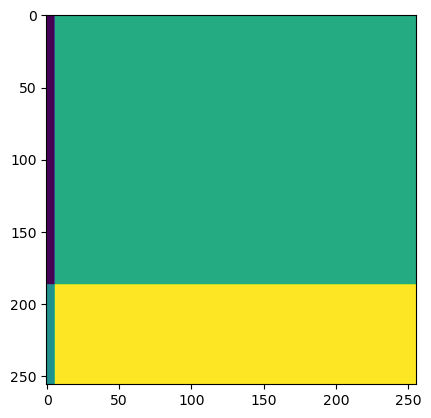

In [21]:
image = image.data_as_image()
imshow(image)